In [66]:
"""
Manish Aradwad / MTech AI / 19494
Pratyush Gauri / MTech AI / 20227
"""

from __future__ import print_function
import time
import tensorflow as tf
from keras import backend
from keras.models import Model
from scipy.optimize import fmin_l_bfgs_b
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from PIL import Image
import urllib.request
tf.compat.v1.disable_eager_execution()

In [67]:
height = 512
width = 512

# This function does all preprocessing needed for only Neural Style Transfer
def preprocess1(content_url, style_url):
  content_img_path = 'content.jpg'
  urllib.request.urlretrieve(content_url, content_img_path)
  content_img = Image.open(content_img_path).resize((width, height))
  
  style_img_path = 'style.jpg'
  urllib.request.urlretrieve(style_url, style_img_path)
  style_img = Image.open(style_img_path).resize((width, height))

  plt.figure(figsize=(18, 18))
  plt.subplot(1, 4, 1)
  plt.imshow(content_img)
  plt.title("Content Image")
  plt.axis("off")

  plt.subplot(1, 4, 2)
  plt.imshow(style_img)
  plt.title("Style Image")
  plt.axis("off")

  content_arr = np.asarray(content_img, dtype='float32')
  content_arr = np.expand_dims(content_arr, axis=0)

  style_arr = np.asarray(style_img, dtype='float32')
  style_arr = np.expand_dims(style_arr, axis=0)

  content_arr[:, :, :, 0] -= 103.939
  content_arr[:, :, :, 1] -= 116.779
  content_arr[:, :, :, 2] -= 123.68
  content_arr = content_arr[:, :, :, ::-1] # Converting RGB to BGR cause paper needs this

  style_arr[:, :, :, 0] -= 103.939
  style_arr[:, :, :, 1] -= 116.779
  style_arr[:, :, :, 2] -= 123.68
  style_arr = style_arr[:, :, :, ::-1] # Converting RGB to BGR cause paper needs this

  content_img = backend.variable(content_arr)
  style_img = backend.variable(style_arr)
  combination_img = backend.placeholder((1, height, width, 3))

  input_tensor = backend.concatenate([content_img, style_img, combination_img], axis=0)

  return input_tensor, combination_img, content_img, style_img

In [68]:
# This function does all preprocessing needed for extension of Neural Style Transfer
def preprocess2(content_url, style1_url, style2_url, style3_url, weights):
  content_img_path = 'content.jpg'
  urllib.request.urlretrieve(content_url, content_img_path)
  content_img = Image.open(content_img_path).resize((width, height))
  
  style1_img_path = 'style1.jpg'
  urllib.request.urlretrieve(style1_url, style1_img_path)
  style1_img = Image.open(style1_img_path).resize((width, height))

  style2_img_path = 'style2.jpg'
  urllib.request.urlretrieve(style2_url, style2_img_path)
  style2_img = Image.open(style2_img_path).resize((width, height))

  style3_img_path = 'style3.jpg'
  urllib.request.urlretrieve(style3_url, style3_img_path)
  style3_img = Image.open(style3_img_path).resize((width, height))

  plt.figure(figsize=(20, 20))
  plt.subplot(1, 4, 1)
  plt.imshow(content_img)
  plt.title("Content Image")
  plt.axis("off")

  plt.subplot(1, 4, 2)
  plt.imshow(style1_img)
  plt.title("Style 1 Image")
  plt.axis("off")

  plt.subplot(1, 4, 3)
  plt.imshow(style2_img)
  plt.title("Style 2 Image")
  plt.axis("off")

  plt.subplot(1, 4, 4)
  plt.imshow(style3_img)
  plt.title("Style 3 Image")
  plt.axis("off")

  content_arr = np.asarray(content_img, dtype='float32')
  content_arr = np.expand_dims(content_arr, axis=0)

  style1_arr = np.asarray(style1_img, dtype='float32')
  style1_arr = np.expand_dims(style1_arr, axis=0)

  style2_arr = np.asarray(style2_img, dtype='float32')
  style2_arr = np.expand_dims(style2_arr, axis=0)

  style3_arr = np.asarray(style3_img, dtype='float32')
  style3_arr = np.expand_dims(style3_arr, axis=0)

  content_arr[:, :, :, 0] -= 103.939
  content_arr[:, :, :, 1] -= 116.779
  content_arr[:, :, :, 2] -= 123.68
  content_arr = content_arr[:, :, :, ::-1] # Converting RGB to BGR cause paper needs this

  style1_arr[:, :, :, 0] -= 103.939
  style1_arr[:, :, :, 1] -= 116.779
  style1_arr[:, :, :, 2] -= 123.68
  style1_arr = style1_arr[:, :, :, ::-1] # Converting RGB to BGR cause paper needs this

  style2_arr[:, :, :, 0] -= 103.939
  style2_arr[:, :, :, 1] -= 116.779
  style2_arr[:, :, :, 2] -= 123.68
  style2_arr = style2_arr[:, :, :, ::-1] # Converting RGB to BGR cause paper needs this

  style3_arr[:, :, :, 0] -= 103.939
  style3_arr[:, :, :, 1] -= 116.779
  style3_arr[:, :, :, 2] -= 123.68
  style3_arr = style3_arr[:, :, :, ::-1] # Converting RGB to BGR cause paper needs this

  # Following code combines the styles of all 3 images which is then used to generate output
  style_arr = weights[0] * style1_arr + weights[1] * style2_arr + weights[2] * style3_arr 

  content_img = backend.variable(content_arr)
  style_img = backend.variable(style_arr)
  combination_img = backend.placeholder((1, height, width, 3))

  input_tensor = backend.concatenate([content_img, style_img, combination_img], axis=0)

  return input_tensor, combination_img, content_img, style1_img, style2_img, style3_img

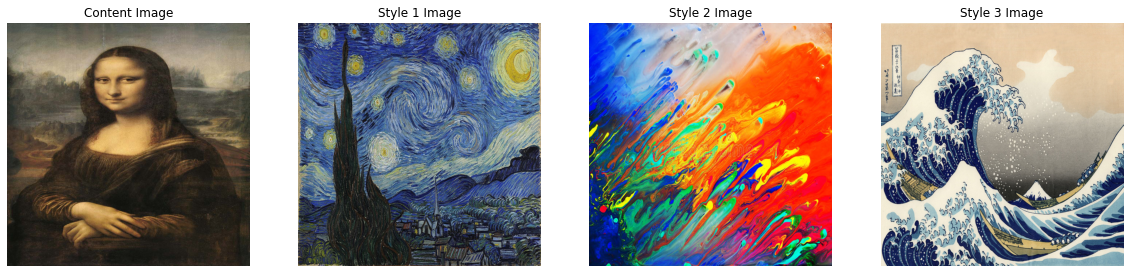

In [69]:
# Use type = 1 for single style output and type = 2 for 3 style output
type = 2

content_url = "https://uploads0.wikiart.org/00339/images/leonardo-da-vinci/mona-lisa-c-1503-1519.jpg"

if type == 1:
  # Can play around with these weights
  content_weight = 0.05
  style_weight = 5.0
  total_variation_weight = 1.0
  style_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg"
  input_tensor, combination_img, content_img, style_img = preprocess1(content_url, style_url)

else:
  # Can play around with these weights
  content_weight = 0.05
  style_weight = 5.0
  total_variation_weight = 1.0

  style1_url = "https://www.worldatlas.com/r/w1200/upload/1f/e7/fd/1280px-van-gogh-starry-night-google-art-project.jpg"
  style2_url = "https://thumbs.dreamstime.com/b/colorful-abstract-acrylic-painting-natural-dynamic-mixture-colors-flow-background-30555980.jpg"
  style3_url = "https://cdn.theculturetrip.com/wp-content/uploads/2012/01/hokusai.jpg"
  style_wts = [0.35, 0.1, 0.45]
  input_tensor, combination_img, content_img, style1_img, style2_img, style3_img = preprocess2(content_url, style1_url, style2_url, style3_url, style_wts)

In [84]:
# VGG16 is used as pretrained CNN model
model = VGG16(input_tensor = input_tensor, weights='imagenet', include_top=False)
layers = dict([(layer.name, layer.output) for layer in model.layers])

In [71]:
loss = backend.variable(0.)

In [72]:
# Function to calculate content loss
def content_loss(content, combination):
  return backend.sum(backend.square(combination - content))

layer_features = layers['block3_conv3']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(content_image_features, combination_features)

In [73]:
# Gram matrix is used for style loss calculation
def gram_matrix(x):
  features = backend.batch_flatten(backend.permute_dimensions(x, (2,0,1)))
  gram = backend.dot(features, backend.transpose(features))
  return gram

# Function to calculate style loss
def style_loss(style, combination):
  S = gram_matrix(style)
  C = gram_matrix(combination)
  channels = 3
  size = height * width
  return backend.sum(backend.square(S-C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']

for layer in feature_layers:
  layer_features = layers[layer]
  style_features = layer_features[1, :, :, :]
  combination_features = layer_features[2, :, :, :]
  sl = style_loss(style_features, combination_features)
  loss = loss + (style_weight / len(feature_layers)) * sl

In [74]:
# Total variation loss helps to remove ringing artifacts
def total_variation_loss(x):
  a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
  b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
  return backend.sum(backend.pow(a + b, 1.25))

loss = loss + total_variation_weight * total_variation_loss(combination_img)

In [75]:
grads = backend.gradients(loss, combination_img)

In [76]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_img], outputs)

def eval_loss_and_grads(x):
  x = x.reshape((1, height, width, 3))
  outs = f_outputs([x])
  loss_value = outs[0]
  grad_values = outs[1].flatten().astype('float64')
  return loss_value, grad_values

class Evaluator(object):
  def __init__(self):
    self.loss_value = None
    self.grads_values = None

  def loss(self, x):
    assert self.loss_value is None
    loss_value, grad_values = eval_loss_and_grads(x)
    self.loss_value = loss_value
    self.grad_values = grad_values
    return self.loss_value
  
  def grads(self, x):
    assert self.loss_value is not None
    grad_values = np.copy(self.grad_values)
    self.loss_value = None
    self.grad_values = None
    return grad_values

evaluator = Evaluator()

In [77]:
def display(iter=50):
  x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

  for i in range(iter):
    print("Iteration:", i)
    start = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun=20)
    print("Current loss value:", min_val)
    end = time.time()
    print("Iteration %d completed in %dseconds\n" %(i, end - start))

  x = x.reshape((height, width, 3))
  x = x[:, :, ::-1]
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = np.clip(x, 0, 255).astype('uint8')
  plt.figure(figsize=(10, 10))
  plt.imshow(x)
  plt.axis("off")
  plt.title("Generated Image")

Iteration: 0
Current loss value: 18466259000.0
Iteration 0 completed in 6seconds

Iteration: 1
Current loss value: 10798500000.0
Iteration 1 completed in 6seconds

Iteration: 2
Current loss value: 8968348000.0
Iteration 2 completed in 6seconds

Iteration: 3
Current loss value: 8250414000.0
Iteration 3 completed in 6seconds

Iteration: 4
Current loss value: 7858674700.0
Iteration 4 completed in 6seconds

Iteration: 5
Current loss value: 7616129000.0
Iteration 5 completed in 6seconds

Iteration: 6
Current loss value: 7448568000.0
Iteration 6 completed in 6seconds

Iteration: 7
Current loss value: 7321220600.0
Iteration 7 completed in 6seconds

Iteration: 8
Current loss value: 7223183400.0
Iteration 8 completed in 6seconds

Iteration: 9
Current loss value: 7147473400.0
Iteration 9 completed in 6seconds



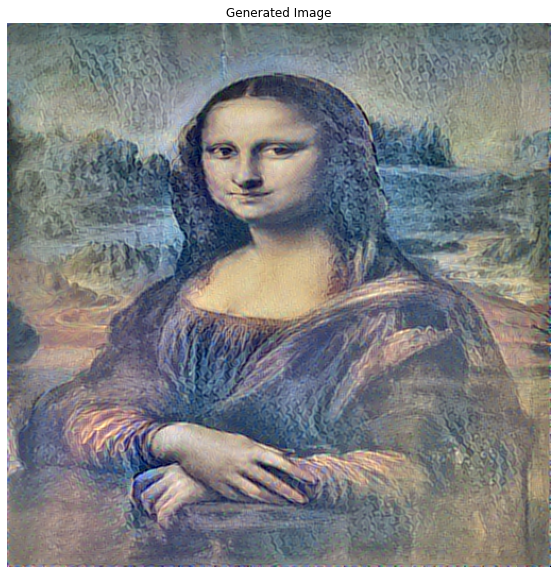

In [78]:
display(10)